In this notebook, we will introduce how to convert pytorch model with custom cuda kernel function to ONNX, then run inference with openvino on CPU.
We use interactive session to compare inference result
- Pytorch model inference on Nvidia GPU
- Pytorch model inference results on Intel CPU
- ONNX model inference results on Intel CPU

Hence, this notebook required both Nvidia GPU and Intel CPU, for cpu only model conversion, please use `convert_model_cpu.py` in the same directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from training.networks import Generator  # ensure the new repo is part of your python path

# your trained network file 
path = "./pretrained/metfaces.pkl"
#path = "./pretrained/ffhq.pkl"

/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Load pytorch model on Nvidia GPU and generate a sample ouput based on a random input latent `z`

Setting up PyTorch plugin "bias_act_plugin"... Failed!


/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/bias_act.py:50: UserWarning: Failed to build CUDA kernels for bias_act. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/bias_act.py", line 48, in _init
    _plugin = custom_ops.get_plugin('bias_act_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1284, in load
    return _jit_compile(
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/utils/cpp_extension.py", line 1467, in _jit_compile
    version = JIT_EXTENS

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/

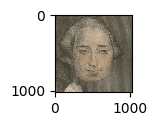

In [3]:
# generate some outputs from the network
# expect some warnings due to missing CUDA and C++ implementations
grid_dim = 1

with open(path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    z = torch.randn([grid_dim*grid_dim, G.z_dim]).cuda()    # latent codes
    c = None                                # class labels (not used in this example)
    out = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
grid = torchvision.utils.make_grid(out.cpu(), nrow=grid_dim)
grid = (grid * 127.5 + 128).clamp(0, 255).to(torch.uint8)

img = grid.detach().numpy()
img = np.transpose(img, (1, 2 ,0))
plt.figure(figsize = (grid_dim, grid_dim))
plt.imshow(img, interpolation='nearest')

Step 2: Create a new model and loaded with Intel CPU, generate a sample output with same input latent `z` 

In [4]:
# create a new network using the new defintion
z2 = z.cpu()
G2 = Generator(
        G.z_dim,  # Input latent (Z) dimensionality.
        G.c_dim,  # Conditioning label (C) dimensionality.
        G.w_dim,  # Intermediate latent (W) dimensionality.
        G.img_resolution,  # Output resolution.
        G.img_channels,
).cpu()

# update the weights to match your trained model
g_sd = G.state_dict()
g2_sd = G2.state_dict()

for k, _ in g2_sd.items():
    g2_sd[k] = g_sd[k]
    
    
G2.load_state_dict(g2_sd)

import functools
G2.forward = functools.partial(G2.forward, c=None, force_fp32=True)

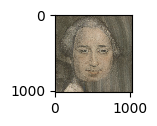

In [5]:
# verify visually that outputs are the same
out = G2(z2)                           # NCHW, float32, dynamic range [-1, +1]
grid = torchvision.utils.make_grid(out.cpu(), nrow=grid_dim)
grid = (grid * 127.5 + 128).clamp(0, 255).to(torch.uint8)

img = grid.detach().numpy()
img = np.transpose(img, (1, 2 ,0))
plt.figure(figsize = (grid_dim, grid_dim))
plt.imshow(img, interpolation='nearest')

Step 3: Export Pytorch Model to ONNX Model

In [6]:
# Export to ONNX
import onnx

def pytorch_exporter(model, batch_size=1, gpu=True):
    if gpu:
        model.cuda()
        test_input_datas = (torch.randn((batch_size, 512), dtype=torch.float32).cuda(), )
    else:
        model.cpu()
        test_input_datas = (torch.randn((batch_size, 512), dtype=torch.float32).cpu(), )
    # generate test outputs
    model.eval()
    outs = model(*test_input_datas)
    scripted_model = torch.jit.trace(model, test_input_datas).eval()

    torch.onnx.export(
        scripted_model,
        *test_input_datas,
        "./model.onnx",
        export_params=True,
        verbose=False,
        input_names=['input0'],
        opset_version=10
    )

In [7]:
pytorch_exporter(G2, batch_size=1, gpu=True)

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/t

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packa

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packa

Failed!


/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/t

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packa

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packa

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu117. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/xsun/workspace/tss/kuaishou/fork/stylegan2-ada-pytorch/t

Failed!


/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/onnx/utils.py:1172: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  params_dict = _C._jit_pass_onnx_constant_fold(
/home/xsun/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/onnx/utils.py:1178: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._j

Step 4: Load ONNX model with openvino, and generate a output based on same input latent `z`

(1, 3, 1024, 1024)


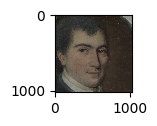

In [9]:
import openvino.runtime as ov
core = ov.Core()
compiled_model = core.compile_model("model.onnx", "CPU")

#test_input_datas = {"input0": np.random.rand(1, 512).astype(np.float32)}
test_input_datas = {"input0": z2.detach().numpy().astype(np.float32)}
results = compiled_model(test_input_datas)
out = results[compiled_model.output(0)]
print(out.shape)
grid = torchvision.utils.make_grid(torch.from_numpy(out), nrow=grid_dim)
grid = (grid * 127.5 + 128).clamp(0, 255).to(torch.uint8)

img = grid.detach().numpy()
img = np.transpose(img, (1, 2 ,0))
plt.figure(figsize = (grid_dim, grid_dim))
plt.imshow(img, interpolation='nearest')